I want to generate data with their classes under the following conditions:
- they contain some correlated variables (2,3,4) for testing
- there is an added noise to the complex functions that will be used in data generation
the fitting algorithm will be as follows:
- 
y = x1^2 + exp(x2x3) + log(x1x4) + sin(2*pi*x5) - tan(3X6+5X7) + X8 noise
x1x2x3 are correlated that means
x2 = 5X1 + noise
x3 = 3x1 + noise
x4 & x5 are also correlated 
X5 = 7X4 + noise
X6, X7 and X8 are independent 

In [2]:
from numpy.random import rand
import numpy as np
from sklearn.preprocessing import MinMaxScaler
np.random.seed(0)

noise_factor = 0
input_dimension = 50000
max_possible = 10

def exp(x1, x2):
    return x1*x2 + x2*x1


def generate_data():
    indep = np.multiply(max_possible,  rand(input_dimension, 10))
#     x1 = indep[0]
#     x2 = 2 * x1 + noise_factor * rand(input_dimension)
#     x3 = 0.25 * x1 + noise_factor * rand(input_dimension)
#     correlated = np.array([x1,x2,x3])
#     non_corr = indep[1:]
#     res = np.concatenate((correlated, non_corr), axis=0)
    return indep

def real_y(x, max_possible=max_possible):
    res = 0
    for i in range(0, len(x), 2):
#         print(x[i], x[i+1], x[i] * x[i+1])
        if (x[i] * x[i+1]) > 0.2 * (max_possible**2):
            res += exp(x[i], x[i+1])
    return res

def test_log(x1, x2):
    return x2 * np.log(x1) + x1 * np.log(x2)



X = generate_data()
X.shape

y = [real_y(x) for x in X]
print(np.average(y))
y_avg =  1 * np.average(y)
y = [1 if x > y_avg else 0 for x in y]
print(np.average(y))

X = MinMaxScaler().fit_transform(X)

dim = X.shape[1]

207.87524420085114
0.47636


In [3]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.5155209461401564

In [4]:
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-3 / 200)
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=X.shape[1], activation='relu'))
	model.add(Dense(8, activation='relu'))
# 	model.add(Dense(8, activation='relu'))
	model.add(Dense(1, activation="sigmoid"))
	# Compile model
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [8]:
model = larger_model()
model.fit(X, y, epochs=5, batch_size=16)

Epoch 1/5
50000/50000 [==============================] - 3s 60us/step - loss: 0.3211 - acc: 0.8571
Epoch 2/5
50000/50000 [==============================] - 3s 55us/step - loss: 0.2465 - acc: 0.8900
Epoch 3/5
50000/50000 [==============================] - 3s 55us/step - loss: 0.2401 - acc: 0.8935
Epoch 4/5
50000/50000 [==============================] - 3s 55us/step - loss: 0.2374 - acc: 0.8926
Epoch 5/5
50000/50000 [==============================] - 3s 55us/step - loss: 0.2364 - acc: 0.8939


In [10]:
def alter(values):
    return np.array([[i[0], 1-i[0]] for i in values])

def get_linear_lime_predictor(predictor):
    return lambda x: alter(predictor(x.T[0:dim].T))

In [11]:
predict_fn = get_linear_lime_predictor(model.predict)

In [21]:
def get_updates(X, weights, feature_names):
    X = X.T
    for i in range(dim - 1, -1, -1):
        for j in range(i-1, -1, -1):
            new_col = np.multiply(X[i], X[j])
            X = np.append(X, [new_col], axis=0)
            feature_names.append(feature_names[i] + feature_names[j])
    X = X.T
    X = MinMaxScaler().fit_transform(X)
    return X, feature_names


PX, new_feature_names = get_updates(X, None, feature_names)
reg = LinearRegression().fit(PX, y)
print(reg.score(PX, y))
all_weights = []
for i, cof in enumerate(reg.coef_):
    all_weights.append((new_feature_names[i], cof))
sorted(all_weights, key= lambda x: -np.abs(x[1]))

0.6285349023536819


[('x6x5', 0.8837848411349345),
 ('x8x7', 0.8814020865663437),
 ('x4x3', 0.878462847561412),
 ('x10x9', 0.8676051196495265),
 ('x2x1', 0.8357178559312285),
 ('x1', 0.3041857939600584),
 ('x5', 0.27962275719159835),
 ('x7', 0.27683632473810943),
 ('x3', 0.2699998795706634),
 ('x6', 0.26641989308554204),
 ('x10', 0.2611529933032409),
 ('x8', 0.2505918987970448),
 ('x9', 0.24896054501419962),
 ('x2', 0.2431360301020348),
 ('x4', 0.22528820216298862),
 ('x7x5', -0.11544802132640486),
 ('x6x3', -0.10630907927346755),
 ('x10x8', -0.09934567018778384),
 ('x6x1', -0.09869813910072293),
 ('x7x1', -0.095290531037768),
 ('x9x1', -0.09208312960242984),
 ('x10x7', -0.09034083110622593),
 ('x9x5', -0.08932222953903918),
 ('x9x3', -0.08840563362686485),
 ('x6x4', -0.08583292715819124),
 ('x8x1', -0.08248107037467708),
 ('x8x6', -0.08059680547237008),
 ('x10x3', -0.08033648913275951),
 ('x5x2', -0.0800694106465979),
 ('x10x1', -0.08005465498304723),
 ('x5x3', -0.0786357590536349),
 ('x7x4', -0.07796932

In [22]:
from data import *
from llime.lime import lime_base, lime_tabular
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
best_kMeans, best_labels, best_n = divide_samples(X, clusters_range=range(5,20))

In [127]:
predictions = model.predict(X)
predictions = [1 if y[0] > 0.5 else 0 for y in predictions]

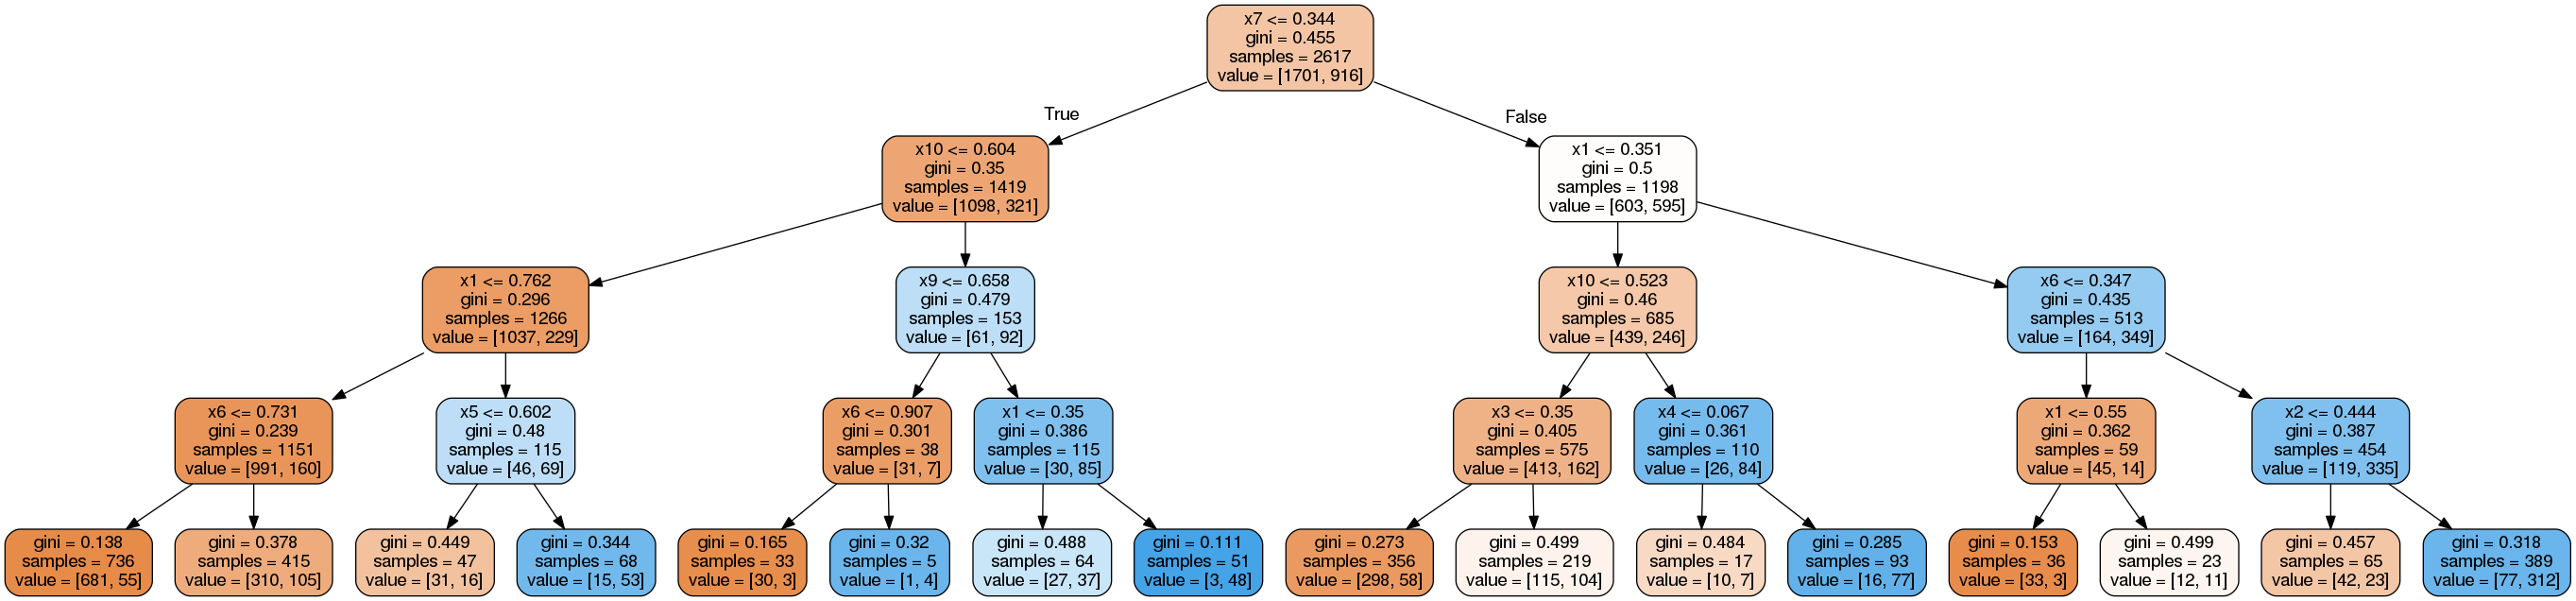

In [138]:
clusters = divide_samples_by_labels(X, best_labels, best_n, predictions)
trees = get_trees_from_clusters(clusters)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
graph = visualize_tree(trees[0], new_feature_names[:dim])
Image(graph.create_png())

In [ ]:
graph = visualize_tree(trees[0], new_feature_names)
Image(graph.create_png())

In [24]:
def explain_sample(sample, explainer, num_features=8):
    exp = explainer.explain_instance(sample, predict_fn, num_features=num_features)
    weights = exp.local_exp[1]
    newX, new_feature_names = get_updates(X, weights, feature_names)
    return weights, newX, new_feature_names

In [25]:
def get_relative_values(weights):
    values = [np.abs(w[1]) for w in weights]
    length = np.sum(values)
    res = []
    for index, weight in weights:
        res.append((index, np.abs(weight)/length))
    return res

In [ ]:
# from data import *
from llime.lime import lime_tabular
%load_ext autoreload
%autoreload 2

In [ ]:
features_weights = dict()
for count in range(200):
    if count%10 == 0:
        print(count)
    i = int(rand() * len(X))
    feature_names = ['x' + str(int(i)) for i in range(1, dim+1)]
    explainer = lime_tabular.LimeTabularExplainer(X,
                                                       class_names=['P', 'N'], 
                                                       feature_names=feature_names,
                                                       verbose=False)
    weights, newX, new_feature_names = explain_sample(X[i], explainer, num_features=8)
    explainer = lime_tabular.LimeTabularExplainer(newX,
                                                       class_names=['P', 'N'], 
                                                       feature_names=new_feature_names,
                                                       verbose=False)
    weights, newX, new_feature_names = explain_sample(newX[i], explainer, num_features=20)
    print(newX.shape)
    weights = get_relative_values(weights)
    print(weights)
    for index, weight in weights:
        feature = feature_names[index]
        if feature not in features_weights:
            features_weights[feature] = 0
        features_weights[feature] +=  weight

In [20]:
sorted([(key, features_weights[key]) for key in features_weights.keys()], key=lambda x: -np.abs(x[1]))

[('x2', 19.114732635503053),
 ('x5', 18.62081426464654),
 ('x3', 18.35881106149149),
 ('x10', 17.920486833689534),
 ('x8', 17.746299245657823),
 ('x6', 17.416940895092893),
 ('x4', 16.657554135984782),
 ('x7', 16.49183700525009),
 ('x1', 15.904103335511984),
 ('x9', 14.794607054805734),
 ('x6x1', 0.8283515527529595),
 ('x5x1', 0.8168618704101178),
 ('x8x3', 0.7555561888558026),
 ('x7x3', 0.7332304539110277),
 ('x6x4', 0.7133642988134845),
 ('x9x2', 0.7096903070639203),
 ('x7x4', 0.6836101229553073),
 ('x10x7', 0.6701243034072041),
 ('x9x3', 0.6661894840057145),
 ('x9x1', 0.6626133071303959),
 ('x10x1', 0.6570581573306977),
 ('x8x1', 0.6524137843505124),
 ('x10x2', 0.6500247592805608),
 ('x8x4', 0.6472311245969927),
 ('x9x5', 0.6389262186934335),
 ('x10x3', 0.6343525387527169),
 ('x9x8', 0.6306497604990567),
 ('x6x2', 0.6249100791015471),
 ('x4x3', 0.6184544136065332),
 ('x6x3', 0.6115210474434817),
 ('x9x6', 0.6072059850601562),
 ('x10x9', 0.6055699646361143),
 ('x10x5', 0.598273649231